# Analyzing Data on Popular Music using Spotify
### by Tanaya Jha, Benjamin Rohd, and Adam Witiak
***
This project is a way to use what we learned about data science and apply it to an interest all of us have in common, music. We learned about Spotify's Web API and wanted to explore the various audio features they collect about each song and how they interact with measures of popularity, genre, and year, and whether there is a meaningful relationship between these factors and Spotify's audio features.


## Reading in Data
First things first, we need to get a dataset. We found a set on [Kaggle](https://www.kaggle.com/) which contains the [Billboard Top 100](https://www.kaggle.com/datasets/dhruvildave/billboard-the-hot-100-songs?resource=download) for every week since 1958. To handle this data, we will need a few libraries:
1. [Pandas](https://pandas.pydata.org/), to store the data as a DataFrame, a 2-D array-like structure. Pandas also has other useful methods to handle data.
2. os, to store and read files, as well as set environment variables. We will need this later.

After downloading the file _charts.csv_ from Kaggle, use the Pandas function [read_csv()](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) to put it into a DataFrame.

In [1]:
import pandas as pd
import os

# Read in data
data = pd.read_csv('charts.csv')

# Get data dimensions
print('Shape of dataset (number of entries vs. # of columns):', data.shape)

# Show a few example entries
data.head()

Shape of dataset (number of entries vs. # of columns): (330087, 7)


,date,rank,song,artist,last-week,peak-rank,weeks-on-board
0,2021-11-06,1,Easy On Me,Adele,1.0,1,3
1,2021-11-06,2,Stay,The Kid LAROI & Justin Bieber,2.0,1,16
2,2021-11-06,3,Industry Baby,Lil Nas X & Jack Harlow,3.0,1,14
3,2021-11-06,4,Fancy Like,Walker Hayes,4.0,3,19
4,2021-11-06,5,Bad Habits,Ed Sheeran,5.0,2,18


Now that we've read in the data, we can take a look at the different fields available to us. 
1. Date, the current week.
1. Rank, a song's ranking in the top 100.
1. Song, the song title.
1. Artist, who made the song. _Note: there may be multiple artists._
1. Last week, which was the ranking of the song in the previous week.
1. Peak rank, the highest rank in the top 100 the song has achieved.
1. Weeks on board, the number of weeks the song has stayed on the chart.

In total, we have 330,087 entries in the DataFrame.

## Step 2: Scraping and Refining from Spotify using SpotiPy
This data is great, but we want to get data on the songs themselves. Luckily, Spotify has a lot of useful data on music. Traits such as danceability, energy, instrumentalness, and loudness are calculated on each song and are accessible via a URI. This URI is unique to each song. _(You can read more about Spotify's audio features [here](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features).)_

To access the Spotify API, we use [SpotiPy](https://spotipy.readthedocs.io/en/2.19.0/#), a python library specifically crafted for interacting with Spotify. It handles all the backend of data requests, token refreshing, and other caveats then wraps everything in methods. To use it, you need a Spotify developer project, which can be created using [this tutorial](https://medium.com/@maxtingle/getting-started-with-spotifys-api-spotipy-197c3dc6353b). SpotiPy requires that certain tokens are set as environment variables.

In [2]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Set environment variables
os.environ["SPOTIPY_CLIENT_ID"] = "OMITTED"
os.environ["SPOTIPY_CLIENT_SECRET"] = "OMITTED"

# Create spotify object
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

For each of the songs in our DataFrame, we need to:
1. Search the song on Spotify, to get the song URI.
2. Use that URI to get the audio features of the song.

We created a function called get_song_data to accomplish this, then applied it to every row of the DataFrame using Pandas' [apply()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) method.

In [3]:
def get_song_data(row):  
    # Pull out each row's song and artist name
    song = row['song']
    artist = row['artist']
    
    # Will be filled with the URI and audio features
    data_list = []
    
    # Search for the song on Spotify: exactly like a user would do when using the actual app
    res1 = sp.search(q='track:'+song+' artist:'+artist[:5],type='track')['tracks']['items']
    
    # Check if a song is returned from the search
    if len(res1) == 0: # if no song found:
        uri = pd.NA
        for i in range(0,10): # Create a 10 feature vector of NA's
            data_list.append(pd.NA)
    else: # if a song is found:
        # Extract URI
        uri = res1[0]['uri']
        
        # From the URI, get the song's audio features
        res2 = sp.audio_features(uri)[0] # Create a 10 feature vector of all the features (including URI)
        
        # Return audio features
        data_list=[uri, res2['danceability'], res2['energy'], res2['loudness'], res2['speechiness'], res2['acousticness'], res2['instrumentalness'], res2['liveness'], res2['valence'], res2['tempo']]
    return data_list

When we run this code thousands of times for every song, we are relying on the fact that Spotify's API does not return any bad requests that would stop our code from running. To circumvent this issue, we split the data into chunks (so we do not lose all our progress if something goes wrong) and use error handling to restart our code.

In [4]:
'''
    chunk: Splits a DataFrame into chunks of a certain size.
    
    Parameters:
        df: the DataFrame to be split.
        chunk_size: the requested size of each chunk. Default: 1000
        
    Returns: a list of DataFrames of length chunk_size. The last DataFrame may be shorter than chunk_size.
'''

def chunk(df, chunk_size = 1000):
    df_chunks = []

    for i in range(int(df.shape[0] / chunk_size)+1):
        df_chunks.append(df.iloc[(i * chunk_size):((i+1) * chunk_size),:])
        
    return df_chunks

The next piece of code is slightly bulky, but its ultimate purpose is to get the audio features for each song.

The initial block with for loops checks which chunks have already been run through the algorithm. It makes sure that if we run this code again, we are not getting the song URIs for songs we have already seen.

The method getAudio is where most of the magic happens. It loops through the chunks, gets the URIs and audio features, stores it in new columns of each dataFrame, and then stores it in a data folder specified by the data_folder variable. The except statement restarts the program if something goes wrong (i.e., Spotify API times out).

In [5]:
import re
curr_num = -1
data_folder = "./data_2017"

# Check what files have been created so far
for root, dirs, files in os.walk(data_folder, topdown=False):
    for name in files:
        
        # If a data file is found, get its number
        r = re.search('^data(\d{1,2})',name)
        if r != None and int(r.group(1)) > curr_num:
            # Update the current number
            curr_num = int(r.group(1))
            
print(curr_num)
            
def getAudio(data, num):
    try:
        # Loop through chunks
        for i,df in enumerate(data):
            
            # If the file for that chunk has not been created
            if (i > num):
                # Apply get_song_data to each song, create new columns
                df[['uri', 'danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness', 'valence', 'tempo']] = df.apply(get_song_data,result_type='expand', axis=1)
                
                # Write the data to a file
                df.to_csv('data'+str(i)+'.csv')
                print('data'+str(i)+'.csv created')
            else:
                print(i,'already created')
    except Exception as e:
        # Handles the exception. Updates the current number and recalls the function
        
        print('---EXCEPTION---')
        # Check what files have already been created
        for root, dirs, files in os.walk(".", topdown=False):
            for name in files:
                r = re.search('^data(\d{1,3})',name)
                if r != None and int(r.group(1)) > num:
                    num = int(r.group(1))
        print('retrying')
        getAudio(data, num)

getAudio(chunk(data), curr_num)

27
0 already created
1 already created
2 already created
3 already created
4 already created
5 already created
6 already created
7 already created
8 already created
9 already created
10 already created
11 already created
12 already created
13 already created
14 already created
15 already created
16 already created
17 already created
18 already created
19 already created
20 already created
21 already created
22 already created
23 already created
24 already created
25 already created
26 already created
27 already created


KeyboardInterrupt: 

After creating the data chunks with the features we need, we need to compile them back together. Use [os.walk()](https://docs.python.org/3/library/os.html#os.walk) to get all the files, then concatenate them. As shown in the DataFrame, new columns were appended that contain the URI and audio features.

In [6]:
# Combine data back into one DataFrame
def combine_data(loc):
    df= pd.DataFrame([])
    for root, dirs, files in os.walk(loc, topdown=False):
        for name in files:
            df = pd.concat([df, pd.read_csv(root+"/"+name)])

    # Refine data
    df = df.reset_index()
    df = df.drop(['Unnamed: 0','index'],axis=1)
    df = df.dropna(subset=['danceability'])
    
    return df

# Create our two datasets
data_peak1 = combine_data('./data_peak1')
data_2017 = combine_data('./data_2017')

In [ ]:
#Run this block to write data to a file in working directory.
data_peak1.to_csv('data_peak1_full.csv')
data_2017.to_csv('data_2017_full.csv')

NameError: ignored

In [7]:
# For Google Colab: read in data from the .csv file
data_peak1 = pd.read_csv('data_peak1_full.csv')
data_2017 = pd.read_csv('data_2017_full.csv')

## Analyzing Audio Features
From the audio features, we can start by analyzing the correlation between the features themselves. A correlation matrix shows the relationship between different variables in data. NumPy has a method [corrcoef()](https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html) to calculate this. In this example, red means a strong positive correlation, white means no correlation, and blue means a strong negative correlation.

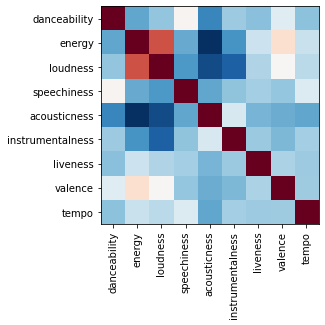

In [8]:
import matplotlib.pyplot as plt
import numpy as np

features = data_2017[['danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness', 'valence', 'tempo']]
features_np = features.to_numpy(dtype=np.float64).T
features_np.shape

correlation_matrix = np.corrcoef(features_np)

names = ['danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness', 'valence', 'tempo']
positions = [0,1,2,3,4,5,6,7,8]

plt.xticks(positions, names, rotation=90)
plt.yticks(positions,names,rotation=0)

# Show the correlation matrix

plt.imshow(correlation_matrix,cmap=plt.get_cmap('RdBu_r'))

From this matrix, we can see meaningful relationships between audio features.
1. Any feature correlates with itself.
1. Loudness and energy correlate strongly. This makes sense, as loud music is generally energetic.
1. Energy and acousticness are negatively correlated. This also makes sense, as acoustic music is generally more calm.
1. Certain features are harder to correlate; for example, valence does not correlate strongly with any other audio feature.

##Audio Features Over Time

In this section we'll explore the relationship between a song's audio features and the year in which it was released. We'll be using tools from [scikit-learn](https://scikit-learn.org/stable/index.html) for machine learning and data analysis.

Let's start by making a copy of the main dataframe so we can manipulate it as we please. 

In [ ]:
data = data_peak1.copy()

Since songs can stay on the charts for multiple weeks, our data has some duplicate entries, which will give the impression that our models are more accurate than they actually are. We use the drop_duplicates method to get rid of all but the first row containing any given song. 

In [ ]:
data = data.drop_duplicates(subset='song', keep="first")

Let's also add a new column to the dataframe which isolates the year from the rest of the date. We do this by converting the date column to a pandas Datetime object, extracting the year, and saving it in a new column called 'year'.

Why we do this will become clear later on, but essentially it makes graphing and modeling the data a bit simpler.

In [ ]:
data['year'] = pd.DatetimeIndex(pd.to_datetime(data['date'])).year

Some of the rows are missing data for all of the audio features, which will present problems when we try to graph. To prevent errors, we use the dropna method to drop any rows with missing values for the danceability column, which will coincide directly with rows missing data for all audio features. 

In [ ]:
data = data.dropna(subset=['danceability'])

If we take a peek at the first and last entries in our dataframe, we can see that the audio features of "Easy On Me" (2021) are vastly different from the audio features of "Love Bites" (1989). 

In [ ]:
data.head(1)

,Unnamed: 0,date,rank,song,artist,last-week,peak-rank,weeks-on-board,year,uri,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0,2021-11-06,1,Easy On Me,Adele,1.0,1,3,2021,spotify:track:0gplL1WMoJ6iYaPgMCL0gX,0.604,0.366,-7.519,0.0282,0.578,0.0,0.133,0.13,141.981


In [ ]:
data.tail(1)

,Unnamed: 0,date,rank,song,artist,last-week,peak-rank,weeks-on-board,year,uri,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
13292,14622,1989-01-14,94,Love Bites,Def Leppard,94.0,1,23,1989,spotify:track:3Dfy8YIxq89i84t108TvMi,0.59,0.743,-7.078,0.0347,0.067,0.00093,0.0847,0.412,129.79


Naturally, we wonder if there have been clear upward or downward trends in some or all of these audio features as popular music has evolved over time. If so, can we use these audio features to predict the year in which a song was released?

To test this, let's create a linear regression model with terms for each of the audio features, and then analyze its ability to predict a song's release year.

We set our X to be the audio features and our Y to be the year. We then split our data into 70% training data and 30% test data so we can test the performance of our model. We use the stratify parameter on Y to make sure our sample split has an equal proportion of entries from each year. We create the model using the training data.


In [ ]:
# import the necessary methods
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# assign X and Y and split the data into training and test data
X = data[['danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness', 'valence', 'tempo']]
Y = data['year']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1, stratify=Y)
# create the linear regression and train it
regr = LinearRegression()
regr.fit(X_train, Y_train)

LinearRegression()

Let's see what happens when we use this model to predict the year of a song. Since it's the last song in the dataframe, we'll use "Love Bites" by Def Leppard.

In [ ]:
regr.predict(data.tail(1)[['danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness', 'valence', 'tempo']])[0]

2001.900748838668

"Love Bites" was released in 1987, so this is not a great prediction, but it could be a lot worse.

With that said, one example is obviously not enough, so let's use the model to make predictions on the entire test data. 

In [ ]:
Y_pred = regr.predict(X_test)

One way to measure the accuracy of our prediction is the mean squared error. This squares the difference between each prediciton and the associated actual value, sums the squared differences, and then divides by the number of predictions. We can use sklearn's mean_squared_error to calculate this. 

In [ ]:
# import the mse method
from sklearn.metrics import mean_squared_error
# output the mean sqaured error between the prediction and test data
mean_squared_error(Y_test,Y_pred)

117.74072941961568

Our model can predict a song's year within roughly 11 years (square root of ~121) based on its audio features. This is decent, but can we make it better? Let's take a closer look at the audio features and see if we can create a more effective model. 

First, let's look at the linear regression model's coefficients for each audio feature to see which are most significant.

In [ ]:
print('Danceability Coefficient: ', regr.coef_[0])
print('Energy Coefficient: ', regr.coef_[1])
print('Loudness Coefficient: ', regr.coef_[2])
print('Speechiness Coefficient: ', regr.coef_[3])
print('Acousticness Coefficient: ', regr.coef_[4])
print('Instrumentalness Coefficient: ', regr.coef_[5])
print('Liveness Coefficient: ', regr.coef_[6])
print('Valence Coefficient: ', regr.coef_[7])
print('Tempo Coefficient: ', regr.coef_[8])

Danceability Coefficient:  24.21714862845959
Energy Coefficient:  -17.52651697454593
Loudness Coefficient:  2.346577901459364
Speechiness Coefficient:  43.28372990168774
Acousticness Coefficient:  -9.119271370731854
Instrumentalness Coefficient:  -7.783013352308388
Liveness Coefficient:  -4.895671400188809
Valence Coefficient:  -17.936874063342717
Tempo Coefficient:  0.015341088418885818


We can see that danceability, energy, and speechiness are by far the most influential factors in our model. Loudness, liveness, and tempo, on the other hand, are mostly insignificant. 

Next, let's graph the features' per-year averages over time to get a better idea of their trends. We create a separate graph for loudness because it is not on a 0 to 1 scale, so its presence would throw off the scale of the graph. We omit tempo for the same reason, and because its coefficient is so low that we know it's mostly independent of time anyway.

We sort the dataframe by year so we can plot the features in order with respect to time. For each feature, we plot year on the x axis, and on the y axis, we group the data by year and find the average for that feature for each year. We plot danceability in blue, energy in green, speechiness in red, acousticness in cyan, instrumentalness in magenta, liveness in yellow, and valence in black. We use matplotlib's subplots to plot loudness over time adjacently. 

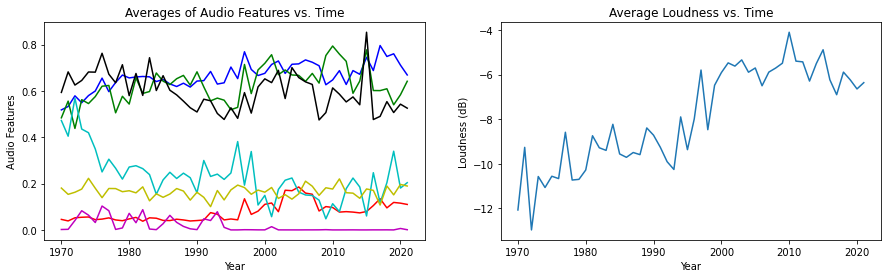

In [ ]:
# sort the dataframe by the year column
data = data.sort_values(by=['year'])
# create a subplots figure to arrange the graphs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
# plot each of the audio features on the first graph
ax1.plot(pd.unique(data['year']), data.groupby(['year'])['danceability'].mean(), 'b')
ax1.plot(pd.unique(data['year']), data.groupby(['year'])['energy'].mean(), 'g')
ax1.plot(pd.unique(data['year']), data.groupby(['year'])['speechiness'].mean(), 'r')
ax1.plot(pd.unique(data['year']), data.groupby(['year'])['acousticness'].mean(), 'c')
ax1.plot(pd.unique(data['year']), data.groupby(['year'])['instrumentalness'].mean(), 'm')
ax1.plot(pd.unique(data['year']), data.groupby(['year'])['liveness'].mean(), 'y')
ax1.plot(pd.unique(data['year']), data.groupby(['year'])['valence'].mean(), 'k')
# label the first graph
ax1.set_title('Averages of Audio Features vs. Time')
ax1.set(xlabel='Year', ylabel='Audio Features')
# plot loudness on the second graph
ax2.plot(pd.unique(data['year']), data.groupby(['year'])['loudness'].mean())
# label the second graph
ax2.set_title('Average Loudness vs. Time')
ax2.set(xlabel='Year', ylabel='Loudness (dB)')
# output the graphs
plt.show()

These graphs illustrate the problem with our previous model: most of these features did not experience linear or strictly increasing/decreasing trends, so we can't expect a linear regression to effectively model the data and make accurate predictions. Specifically notice how valence (black) and acousticness (cyan) fluctuate significantly and irregularly over time. Also, notice that, as the coefficient indicates, liveness (yellow) shows no large scale pattern or trend.

Let's try a non-linear regression approach to see if we can better model this data. Let's also refrain from using the data for loudness, liveness, and tempo, because as we've seen, these features are largely independent of time. 

We'll use sklearn's decision tree regressor, using the same split between training and test data as before. Our input data will be limited to the features we've decided are significant: danceability, energy, speechiness, acousticness, instrumentalness, and valence. 

In [ ]:
# assign X and Y and split the data into training and test data
X = data[['danceability','energy', 'speechiness', 'acousticness','instrumentalness','valence']]
Y = data['year']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1, stratify=Y)

We train the model using the test data.

In [ ]:
# import the decision tree module
from sklearn.tree import DecisionTreeRegressor
# create and train the decision tree
decision_tree = DecisionTreeRegressor(random_state=1)
decision_tree = decision_tree.fit(X_train, Y_train)

And again, we make predictions on the test data and view the mean squared error. 

In [ ]:
# predict using the model
Y_pred_tree = decision_tree.predict(X_test)
# output the mean sqaured error between the prediction and test data
mean_squared_error(Y_test, Y_pred_tree)

270.00411522633743

The result is a mean squared error of 270, which, interestingly enough, is far worse than our linear regression model. Using this, we can successfully predict the year of a song within around 16 years. Considering our data only spans aroun 50 years, this is not very good. This is illustrative of the fact that either: 1. sonic characteristics of popular music do not follow strong concertive trends, or 2. Spotify's audio features are simply not adequate in wholly quantifying these sonic characteristics. In either case, it seems we don't have a way to consistently and accurately predict the year in which a song was released based on its audio features. 

## Audio Features vs. Popularity

In this section, we can explore the various audio features as they relate to popularity in order to see if there are any meaningful correlations and if so, if it is possible to predict some level of popularity for a song based solely off of Spotify's audio features. The first step would be to import the neccessary libraries and datasets. The dataset used here is all the popular songs since 2017, including statistics about their popularity and audio features extracted using Spotify's API.



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.preprocessing as preprocessing
pop_data = pd.read_csv("data_2017_full.csv")

Prior to working with the data, it should be cleaned by removing duplicates. 

In [ ]:
df = pop_data.drop_duplicates(subset='song', keep="first")
print(df.head())

   Unnamed: 0        date  rank           song                         artist  \
0           0  2021-11-06     1     Easy On Me                          Adele   
1           1  2021-11-06     2           Stay  The Kid LAROI & Justin Bieber   
2           2  2021-11-06     3  Industry Baby        Lil Nas X & Jack Harlow   
3           3  2021-11-06     4     Fancy Like                   Walker Hayes   
4           4  2021-11-06     5     Bad Habits                     Ed Sheeran   

   last-week  peak-rank  weeks-on-board                                   uri  \
0        1.0          1               3  spotify:track:0gplL1WMoJ6iYaPgMCL0gX   
1        2.0          1              16  spotify:track:5HCyWlXZPP0y6Gqq8TgA20   
2        3.0          1              14  spotify:track:27NovPIUIRrOZoCHxABJwK   
3        4.0          3              19  spotify:track:58UKC45GPNTflCN6nwCUeF   
4        5.0          2              18  spotify:track:3rmo8F54jFF8OgYsqTxm5d   

   danceability  energy  l

Looking at data available to us, it looks like one measure of popularity we can use here is peak rank. We can generate some graphs to see if a pattern emerges between peak rank and the audio features. 

---



We will be using the audio features to predict the peak rank. Lets save the audio features columns to be used as input later.

In [ ]:
metrics = df.columns[9:17]

First let's see if there is any clear correlation between the features and the peak rank. We can do this by generating a line chart for each metric. Before a chart can be created, we should take the average of each feature that corresponding to each possible peak rank. The average is what will be graphed. The following code will go through each rank, calculate the average for each metric, and add it to a new dataframe called average_df.

In [ ]:
average_df = pd.DataFrame(columns=('rank', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness','instrumentalness', 'liveness', 'valence'))
for rank in range(1,101):
    rank_df=df[metrics] [df['peak-rank'] == rank]
    average_df.loc[rank]=[rank,rank_df[metrics[0]].mean(),rank_df[metrics[1]].mean(),rank_df[metrics[2]].mean(),rank_df[metrics[3]].mean(),rank_df[metrics[4]].mean(),rank_df[metrics[5]].mean(),rank_df[metrics[6]].mean(),rank_df[metrics[7]].mean()]
print(average_df.head())

   rank  danceability    energy  loudness  speechiness  acousticness  \
1   1.0      0.725187  0.594893 -6.401800     0.117704      0.209377   
2   2.0      0.711656  0.623000 -6.192750     0.115234      0.130512   
3   3.0      0.696633  0.615403 -6.841800     0.153003      0.202240   
4   4.0      0.692281  0.661125 -6.111625     0.137287      0.177383   
5   5.0      0.709381  0.644714 -5.903952     0.166881      0.119947   

   instrumentalness  liveness   valence  
1          0.002211  0.180823  0.525935  
2          0.004463  0.150175  0.512937  
3          0.035774  0.202403  0.460067  
4          0.004235  0.200759  0.489250  
5          0.001333  0.167676  0.525305  


Now let's plot the averages:

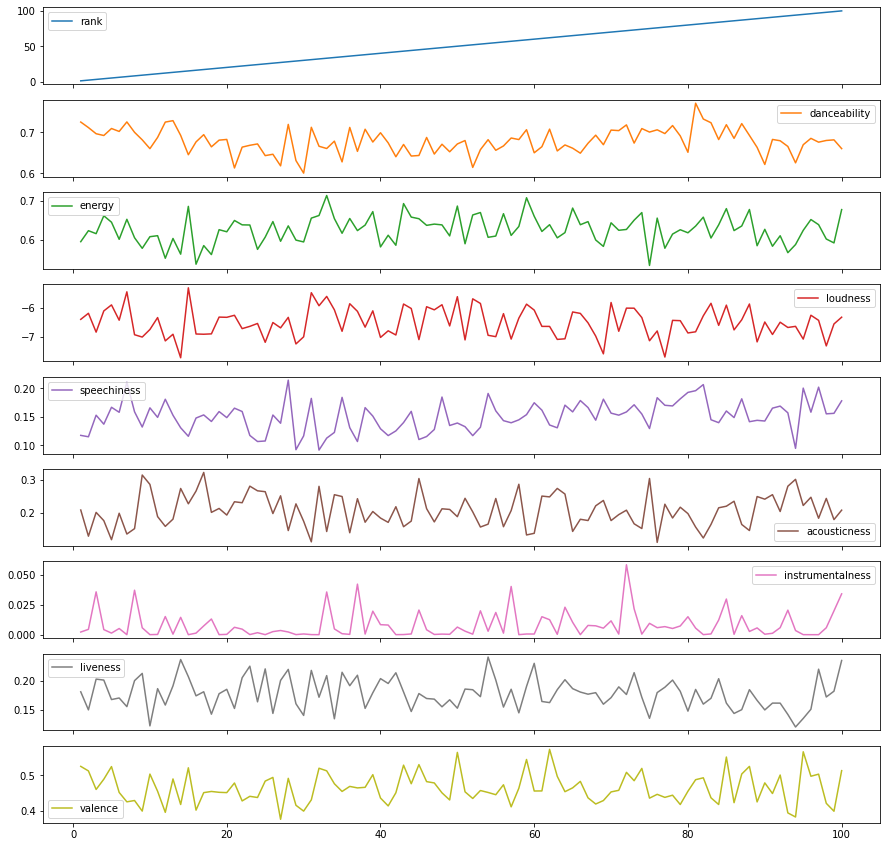

In [ ]:
axes = average_df.plot.line(subplots=True,figsize=(15,15))

There doesn't appear to be any clear correlations by looking at the charts. The values seem pretty arbitrary and not directly correlated to the peak rank, but there may be an underlying relationship between all the input variables that may be connected to the peak rank. 

We can try building a few machine learning models to see how realistic it would be to be able to predict the peak rank from just these audio features. Even from a lack of a clear relationship, there are algorithms that can utilize the data in such a way that can generate predictions from more complex (and less noticeable) patterns. For this project, we can build a decision tree classifier and then a random forest classifer (uses outputs from multiple decision trees for a prediction). Lets start by importing everything we need for the models we will build. 

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

Next, let's prepare the data for training by splitting it into separate datasets for training and testing, and also by normalizing the input values. 

In [ ]:
X = df[metrics]
y = df["peak-rank"]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
scaler = MinMaxScaler(feature_range = (0, 1))
X = scaler.fit_transform(X)

Now let's build the decision tree classifier and test it out on the test set. The metric we are using to assess these models is the root mean square error, which essentially gives us an idea of how many ranks away our predictions are from the actual value, on average. The smaller this metric is, the better. 

In [ ]:
regr = DecisionTreeRegressor(max_depth=10)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
rmse = mean_squared_error(y_test, y_pred,squared=False)
print('RMSE: ', rmse)

RMSE:  35.20597408868993


Next, let's do the random forest classifier. This an algorithm that is related to the decision tree because it builds decision trees from several samples and bases a final prediction from all the trees. It is supposedly more accurate than a single decision tree, specifically on new and unfamiliar data because it has less overfitting. This means it generalizes well to other data outside the training set, which makes sense since that random forest predicts from many trees from many smaller samples, as opposed to one single tree generated off of the whole data set. 

In [ ]:
regr = RandomForestClassifier(max_depth=20,n_estimators=100,min_samples_leaf=5)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
rmse = mean_squared_error(y_test, y_pred,squared=False)
print('RMSE: ', rmse)

RMSE:  43.40120875581657


Based off of the RMSE's, it looks like the random forest did not do as well as the decision tree. This is surprising considering that the random forest is supposed to do well due to its ability to avoid overfitting. Random forest tends to do much better on larger datasets because it allows for more/bigger samples to train off of; this dataset is relatively small. Also, its ability to generalize well to other dataset may come at a cost of accuracy on data that is very similar to the training set, simply due to the fact that to avoid overfitting, some information regarding the training data needs to be thrown away so it does not fit too closely. 

Overall, the predictions from the two models are not that great due to the high RMSE's, so adding more relevant features may help improve predictions. It seems that all the songs on the top song list have similar audio features, which makes sense considering that most are pop songs. Although it is possible that smaller differences may distinguish songs that hit 1 as their peak rank versus songs that could only get up to 50, but it is unlikely that any such difference would be solely attributable to audio features. 

## Conclusion
From our findings, we decided that Spotify's audio features alone cannot accurately predict time or popularity about songs. Our models could only predict within a certain range of the correct answers. We believe that there are a number of variables missing from this data that we did not account for (i.e., trends in music or the limitations of the audio features themselves). 

However, the audio features are useful to look at in a vacuum. Popular songs share high energy, valence, and danceability. 

More research can be done to discover more meaningful variables and accurately predict time, popularity, or other factors.

***

_This code is avaiable on the [GitHub repo](https://github.com/adamwitiak/adamwitiak.github.io)._

&nbsp;

&nbsp;

&nbsp;